<a href="https://colab.research.google.com/github/shaina-12/Artificial-Intelligence/blob/main/Computer%20Vision/Codes/Image_Classification_usingLeNet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
path_normal = "/content/drive/My Drive/Colab Notebooks/COVID-19_Radiography_Dataset/Normal/"
path_covid = "/content/drive/My Drive/Colab Notebooks/COVID-19_Radiography_Dataset/COVID/"

In [ ]:
len_normal = len(os.listdir(path_normal))
len_covid = len(os.listdir(path_covid))

In [ ]:
print(len_normal)
print(len_covid)

10192
3616


In [ ]:
objects = ('Normal', 'COVID-19')
y_pos = np.arange(len(objects))
performance = [len_normal, len_covid]

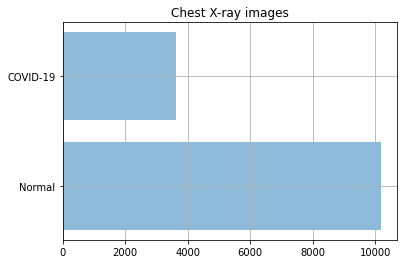

In [ ]:
plt.barh(y_pos,performance,align='center',alpha=0.5)
plt.grid()
plt.yticks(y_pos, objects)
plt.title('Chest X-ray images')
plt.show()

In [ ]:
labels = ['Normal', 'COVID-19']
img1 = path_normal+"/Normal-1.png"
img2 = path_covid+"/COVID-1.png"
imgs = [img1, img2]

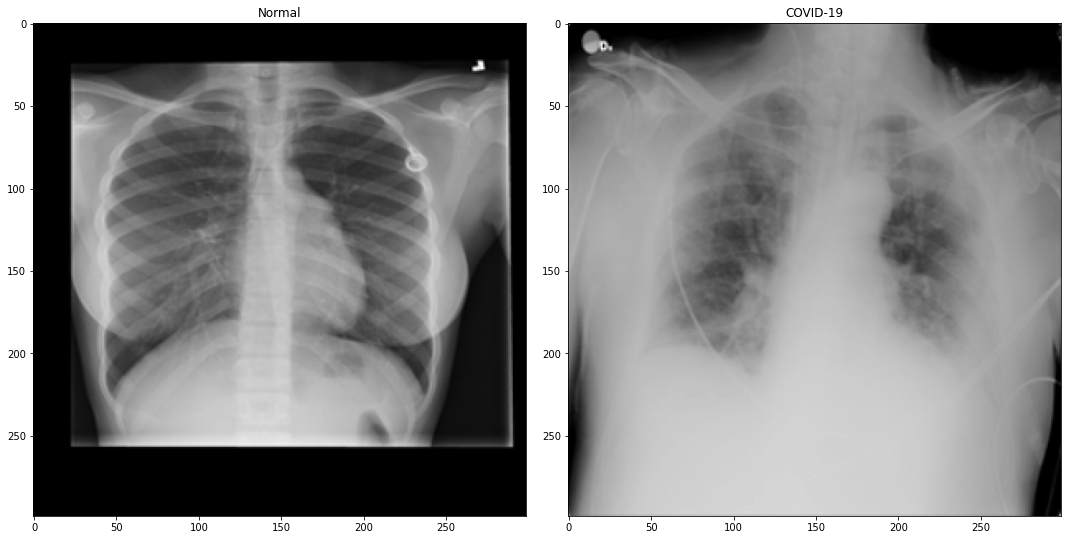

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax = ax.ravel()
plt.tight_layout()
ax = ax.ravel()
plt.tight_layout()
for i in range(0,2):
    ax[i].imshow(plt.imread(imgs[i]), cmap='gray')
    ax[i].set_title(labels[i])

In [ ]:
levels = ['Normal', 'COVID']
path = "/content/drive/My Drive/Colab Notebooks/COVID-19_Radiography_Dataset/"
data_dir = os.path.join(path)
data = []
for id, level in enumerate(levels):
    for file in os.listdir(os.path.join(data_dir, level)):
        data.append(['{}/{}'.format(level, file), level])
data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])
data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 0, 'COVID': 1})
data.head()

,image_file,corona_result,path
0,Normal/Normal-9103.png,0,/content/drive/My Drive/Colab Notebooks/COVID-...
1,Normal/Normal-9090.png,0,/content/drive/My Drive/Colab Notebooks/COVID-...
2,Normal/Normal-908.png,0,/content/drive/My Drive/Colab Notebooks/COVID-...
3,Normal/Normal-9087.png,0,/content/drive/My Drive/Colab Notebooks/COVID-...
4,Normal/Normal-909.png,0,/content/drive/My Drive/Colab Notebooks/COVID-...


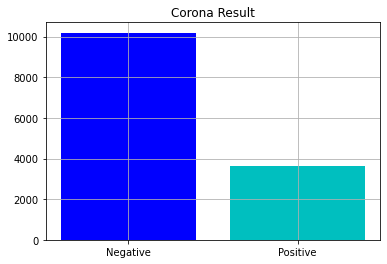

In [ ]:
df = pd.DataFrame()
df['corona_result'] = ['Negative','Positive']
df['count'] = [len(data[data['corona_result'] == 0]), len(data[data['corona_result'] == 1])]
df = df.sort_values(by = ['count'], ascending = False)
x = list(np.arange(2))
y = list(df['count'])
plt.bar(x,y,color=['b','c'])
plt.grid()
plt.xticks(x,['Negative','Positive'])
plt.title('Corona Result')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as da
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io

In [ ]:
class ImageDataset(Dataset):
    def __init__(self,d,transform=None):
        self.annotations = d
        self.transform = transform
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self,index):
        image = io.imread(os.path.join("",self.annotations.iloc[index, 2]))
        label = torch.tensor(int(self.annotations.iloc[index, 1]))
        if self.transform:
            image = self.transform(image)
        image = torch.reshape(image, (1,64,64))
        return (image, label)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
my_transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((64,64)),
              transforms.ToTensor(),
              transforms.Normalize((0.5),(0.5))
])
dataset = ImageDataset(d=data, transform=my_transform)

In [ ]:
train_size = int(0.80 * len(dataset))
test_size = int(len(dataset) - train_size)
train_set, test_set = torch.utils.data.random_split(dataset,[train_size, test_size])

In [ ]:
def calculate_accuracy(y_pred, y):
    best_pred = y_pred.argmax(1, keepdim=True)
    correct = best_pred.eq(y.view_as(best_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def loop_train(model, test_iterator, train_iterator, optimizer, criterion, device, epochs):
    best_value_loss = float('inf')
    count_stop = 0
    
    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        if test_loss < best_value_loss:
            count_stop = 0
            best_value_loss = test_loss
        else:
            count_stop += 1

        print(f'Epoch: {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')
        
        if count_stop == 2:
            print('Aborting train...')
            return

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=9720, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )
    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) #transforma a matrix x em vetor.
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
#paramrs
epochs = 10
batch_size = 128
train_loader = DataLoader(dataset=train_set, batch_size=batch_size)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size)
model = LeNet5(2)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
model.to(device)
criterion.to(device)
loop_train(model, test_loader, train_loader, optimizer, criterion, device, epochs)

Epoch: 1
	Train Loss: 0.465 | Train Acc: 77.68%
	 Test. Loss: 0.377 |  Test. Acc: 84.05%
Epoch: 2
	Train Loss: 0.341 | Train Acc: 84.80%
	 Test. Loss: 0.292 |  Test. Acc: 87.05%
Epoch: 3
	Train Loss: 0.298 | Train Acc: 86.68%
	 Test. Loss: 0.266 |  Test. Acc: 88.40%
Epoch: 4
	Train Loss: 0.261 | Train Acc: 88.62%
	 Test. Loss: 0.254 |  Test. Acc: 88.96%
Epoch: 5
	Train Loss: 0.236 | Train Acc: 89.88%
	 Test. Loss: 0.223 |  Test. Acc: 90.15%
Epoch: 6
	Train Loss: 0.211 | Train Acc: 91.16%
	 Test. Loss: 0.198 |  Test. Acc: 91.80%
Epoch: 7
	Train Loss: 0.188 | Train Acc: 92.24%
	 Test. Loss: 0.187 |  Test. Acc: 92.50%
Epoch: 8
	Train Loss: 0.169 | Train Acc: 92.99%
	 Test. Loss: 0.184 |  Test. Acc: 92.16%
Epoch: 9
	Train Loss: 0.151 | Train Acc: 94.05%
	 Test. Loss: 0.193 |  Test. Acc: 91.63%
Epoch: 10
	Train Loss: 0.136 | Train Acc: 94.49%
	 Test. Loss: 0.195 |  Test. Acc: 91.87%
Aborting train...
